In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit

In [6]:
path = Path.cwd()
datapath = path / 'spectroscopydata'
outputpath = path / 'spectroscopyresults'

In [2]:
u = 1.6605 * 1e-27
m85 = 84.91 * u	
m87 = 86.91 * u	 
c = 299792458
kB = 1.380649 * 1e-23

In [3]:
def lorentzian(x,A,mean,gamma):
    return A/(1+4*(x-mean)**2/gamma**2)

def shifted_lorentzian(x,A,mean,gamma,offset):
    return lorentzian(x,A,mean,gamma)+offset

def gaussian(x,A,mean,std):
    return -A/np.sqrt(2*np.pi*std**2)*np.exp(-0.5*(x-mean)**2/std**2)

def shifted_gaussian(x,A,mean,std,offset,slope):
    return gaussian(x,A,mean,std)+offset+slope*x

def global_gaussian(x,A1,A2,A3,A4,mean1,mean2,mean3,mean4,std1,std2,std3,std4,offset,slope):
    return gaussian(x,A1,mean1,std1)+gaussian(x,A2,mean2,std2)+gaussian(x,A3,mean3,std3)+gaussian(x,A4,mean4,std4)+offset+slope*x

In [4]:
def set_mask(x,boundl,boundr):
    mask = np.logical_and(boundl < x, x < boundr)
    return mask
    
def interpolate_zero_between(x,y,idl,idr):
    a = y[idl]
    b = (y[idr]-y[idl])/(x[idr]-x[idl])
    return -a/b+x[idl]

# EXTRA: Global Calibration Single Multiplet Fits

In [7]:
data = pd.read_csv(datapath/'DigiLock-ScopeData.txt', sep="\t")
data_nr = pd.read_csv(datapath/'DigiLock-ScopeData_norepump.txt', sep = "\t")
timebase = 50 * 1e-3
divisions = 4
timeaxis = np.linspace(0,divisions*timebase,len(data_nr['Aux out [V]']))

Text(0.5, 1.0, 'Repump off')

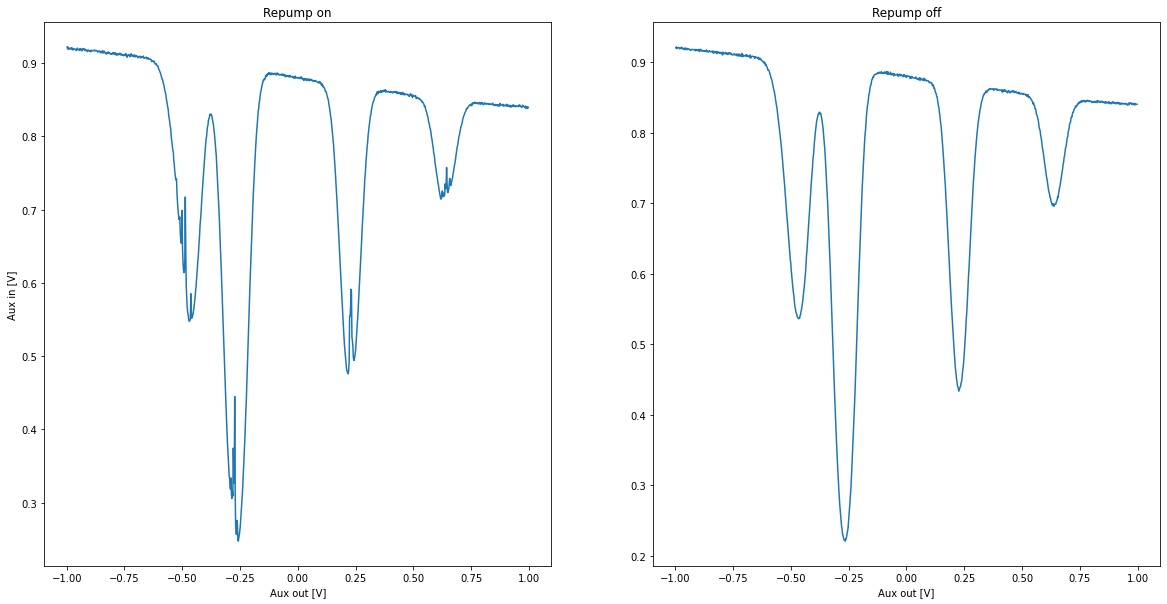

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [48]:
mask1 = set_mask(data['Aux out [V]'],-0.6,-0.38)
popt1, pcov1 = curve_fit(shifted_gaussian,data_nr['Aux out [V]'][mask1],data_nr['Aux in [V]'][mask1],bounds=([0,-0.6,0,0,-1],[1,-0.38,0.5,1,1]))
perr1 = np.sqrt(np.diag(pcov1))

mask2 = set_mask(data['Aux out [V]'],-0.36,-0.18)
popt2, pcov2 = curve_fit(shifted_gaussian,data_nr['Aux out [V]'][mask2],data_nr['Aux in [V]'][mask2],bounds=([0,-0.36,0,0,-1],[1,-0.18,0.5,1,1]))
perr2 = np.sqrt(np.diag(pcov2))

mask3 = set_mask(data['Aux out [V]'],0.05,0.45)
popt3, pcov3 = curve_fit(shifted_gaussian,data_nr['Aux out [V]'][mask3],data_nr['Aux in [V]'][mask3],bounds=([0,0.05,0,0,-1],[1,0.45,0.5,1,1]))
perr3 = np.sqrt(np.diag(pcov3))

mask4 = set_mask(data['Aux out [V]'],0.5,0.8)
popt4, pcov4 = curve_fit(shifted_gaussian,data_nr['Aux out [V]'][mask4],data_nr['Aux in [V]'][mask4],bounds=([0,0.5,0,0,-1],[1,0.8,0.5,1,1]))
perr4 = np.sqrt(np.diag(pcov4))

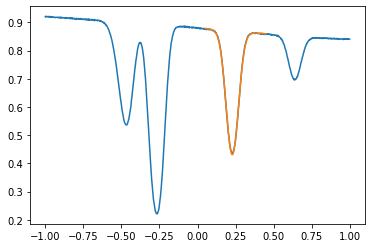

In [47]:
mask = set_mask(data['Aux out [V]'],0.05,0.45)
poptt, pcovt = curve_fit(shifted_gaussian,data_nr['Aux out [V]'][mask],data_nr['Aux in [V]'][mask],bounds=([0,0.05,0,0,-1],[1,0.45,0.5,1,1]))
plt.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'])
plt.plot(data_nr['Aux out [V]'][mask],shifted_gaussian(data_nr['Aux out [V]'][mask],*poptt))

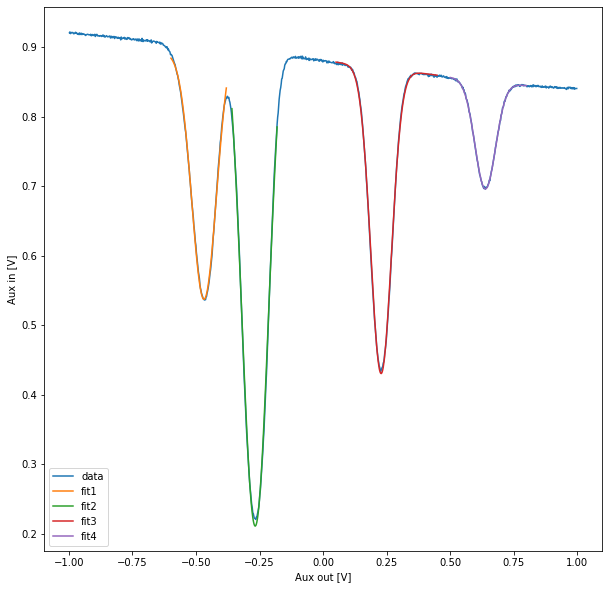

In [61]:
plt.figure(figsize = (10,10))
plt.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
plt.plot(data_nr['Aux out [V]'][mask1], shifted_gaussian(data_nr['Aux out [V]'][mask1],*popt1),label='fit1')
plt.plot(data_nr['Aux out [V]'][mask2], shifted_gaussian(data_nr['Aux out [V]'][mask2],*popt2),label='fit2')
plt.plot(data_nr['Aux out [V]'][mask3], shifted_gaussian(data_nr['Aux out [V]'][mask3],*popt3),label='fit3')
plt.plot(data_nr['Aux out [V]'][mask4], shifted_gaussian(data_nr['Aux out [V]'][mask4],*popt4),label='fit4')
plt.xlabel('Aux out [V]')
plt.ylabel('Aux in [V]')
plt.legend()
plt.show()


In [60]:
print("{:.5f}+-{:.5f}".format(popt1[1],perr1[1]))
print("{:.5f}+-{:.5f}".format(popt2[1],perr2[1]))
print("{:.5f}+-{:.5f}".format(popt3[1],perr3[1]))
print("{:.5f}+-{:.5f}".format(popt4[1],perr4[1]))

-0.46804+-0.00025
-0.26709+-0.00029
0.22795+-0.00006
0.63784+-0.00008


In [53]:
print("Use 87Rb F=2 -> F' and 87Rb F=1 -> F' for calibration.")
delta_t = (popt4[1]-popt1[1])
delta_t_err = np.sqrt(perr4[1]**2+perr1[1]**2)
print("Time difference: ({:f} +/- {:f}) s".format(delta_t,delta_t_err))
print("Literaturwert: 6.834682 GHz")
K = 6.834682/delta_t
K_err = 6.834682/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) GHz/s".format(K,K_err))

Use 87Rb F=2 -> F' and 87Rb F=1 -> F' for calibration.
Time difference: (1.105877 +/- 0.000264) s
Literaturwert: 6.834682 GHz
Kalibrierungsfaktor K = (6.180 +/- 0.001) GHz/s


In [55]:
print("Frequenzabstand 85Rb F=3 -> F':")
dt = (popt2[1]-popt1[1])
dt_err = np.sqrt(perr2[1]**2+perr1[1]**2) 
f = K * dt
f_err = np.sqrt((dt*K_err)**2+(K*dt_err)**2)
print("Messung: ({:.4f} +/- {:.4f}) GHz".format(f,f_err))
print("Theorie: 1.298 GHz")
print("rel. Abweichung: {:.2f}%".format((f-1.298)/1.298*100))

Frequenzabstand 85Rb F=3 -> F':
Messung: (1.2419 +/- 0.0024) GHz
Theorie: 1.298 GHz
rel. Abweichung: -4.32%


In [56]:
print("Frequenzabstand 85Rb F=2 -> F':")
dt = (popt3[1]-popt1[1])
dt_err = np.sqrt(perr3[1]**2+perr1[1]**2) 
f = K * dt
f_err = np.sqrt((dt*K_err)**2+(K*dt_err)**2)
print("Messung: ({:.4f} +/- {:.4f}) GHz".format(f,f_err))
print("Theorie: 4.33 GHz")
print("rel. Abweichung: {:.2f}%".format((f-4.33)/4.33*100))

Frequenzabstand 85Rb F=2 -> F':
Messung: (4.3014 +/- 0.0019) GHz
Theorie: 4.33 GHz
rel. Abweichung: -0.66%
